# Hospital Patient Data Analysis

1. Load and Explore the Data:

-Load the patient data into a PySpark DataFrame.

-Check for missing values, data types, and general statistics.

In [6]:
patient_df=spark.read\
.format("csv")\
.option("inferSchema","true")\
.option("header","true")\
.load("/public/trendytech/datasets/hospital.csv")

In [110]:
patient_df.show()

+----------+--------------+--------------+-------------+---------+----------+
|patient_id|admission_date|discharge_date|    diagnosis|doctor_id|total_cost|
+----------+--------------+--------------+-------------+---------+----------+
|         1|    01-01-2022|    2022-01-10|    Pneumonia|      101|    5000.0|
|         2|    02-05-2022|    2022-02-09| Appendicitis|      102|    7000.0|
|         3|    03-12-2022|    2022-03-18|Fractured Arm|      103|    3500.0|
|         4|    04-02-2022|    2022-04-08| Heart Attack|      104|   15000.0|
|         5|    05-05-2022|    2022-05-07|    Influenza|      105|    2500.0|
|         6|    06-10-2022|    2022-06-15| Appendicitis|      106|    8000.0|
|         7|    07-20-2022|    2022-07-25|    Pneumonia|      107|    5500.0|
|         8|    08-25-2022|    2022-09-01| Heart Attack|      108|   20000.0|
|         9|    09-15-2022|    2022-09-22|Fractured Leg|      109|    6000.0|
|        10|    10-05-2022|    2022-10-10| Appendicitis|      11

In [56]:
patient_df.printSchema()

root
 |-- patient_id: integer (nullable = true)
 |-- admission_date: string (nullable = true)
 |-- discharge_date: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- doctor_id: integer (nullable = true)
 |-- total_cost: double (nullable = true)



In [57]:
patient_df.describe().show()

+-------+-----------------+--------------+--------------+------------+-----------------+----------------+
|summary|       patient_id|admission_date|discharge_date|   diagnosis|        doctor_id|      total_cost|
+-------+-----------------+--------------+--------------+------------+-----------------+----------------+
|  count|               25|            25|            25|          25|               25|              25|
|   mean|             13.0|          null|          null|        null|            113.0|          7680.0|
| stddev|7.359800721939872|          null|          null|        null|7.359800721939872|5614.26753904728|
|    min|                1|    01-01-2022|    2022-01-10|Appendicitis|              101|          2500.0|
|    max|               25|    12-10-2022|    2024-01-15|   Pneumonia|              125|         21000.0|
+-------+-----------------+--------------+--------------+------------+-----------------+----------------+



2.Common Diagnoses and Associated Costs:

-Identify the most common diagnoses.

-Calculate the total cost for each diagnosis.

In [58]:
from pyspark.sql.functions import *

In [59]:
common_diagnoses_df = patient_df.groupBy("diagnosis").agg(
    col("diagnosis"),
    (count(col("patient_id")).alias("num_patients")),
    (sum(col("total_cost")).alias("total_cost"))
).orderBy(col("num_patients").desc())

In [60]:
common_diagnoses_df.show()

+-------------+-------------+------------+----------+
|    diagnosis|    diagnosis|num_patients|total_cost|
+-------------+-------------+------------+----------+
| Heart Attack| Heart Attack|           5|   90000.0|
| Appendicitis| Appendicitis|           5|   37500.0|
|    Influenza|    Influenza|           5|   14100.0|
|    Pneumonia|    Pneumonia|           5|   26500.0|
|Fractured Arm|Fractured Arm|           3|   11400.0|
|Fractured Leg|Fractured Leg|           2|   12500.0|
+-------------+-------------+------------+----------+



3. Relationship Between Diagnoses and Total Costs:
    
-Examine the relationship between different diagnoses and their associated costs.

In [61]:
diagnosis_cost_relation_df = patient_df.groupBy("diagnosis").agg(F.avg("total_cost").alias("avg_cost"))
diagnosis_cost_relation_df.show()


+-------------+--------+
|    diagnosis|avg_cost|
+-------------+--------+
| Heart Attack| 18000.0|
|Fractured Arm|  3800.0|
|Fractured Leg|  6250.0|
| Appendicitis|  7500.0|
|    Influenza|  2820.0|
|    Pneumonia|  5300.0|
+-------------+--------+



4. Performance of Doctors Based on Total Costs:

Analyze the average total cost of treatments for each doctor.

In [62]:
doctor_performance_df = patient_df.groupBy("doctor_id").agg(F.avg("total_cost").alias("avg_total_cost"))
doctor_performance_df.show()


+---------+--------------+
|doctor_id|avg_total_cost|
+---------+--------------+
|      108|       20000.0|
|      101|        5000.0|
|      115|        3800.0|
|      103|        3500.0|
|      122|       21000.0|
|      111|        2800.0|
|      120|        7800.0|
|      117|       16000.0|
|      112|        6000.0|
|      107|        5500.0|
|      114|        7200.0|
|      102|        7000.0|
|      113|       18000.0|
|      121|        2900.0|
|      125|        3200.0|
|      109|        6000.0|
|      105|        2500.0|
|      110|        7500.0|
|      106|        8000.0|
|      116|        2700.0|
+---------+--------------+
only showing top 20 rows



5. Most Expensive Diagnoses:

    -Identify the diagnoses with the highest average total cost.

In [89]:
expensive_diagnoses_df = patient_df.groupBy("diagnosis").agg(
    F.count("patient_id").alias("num_patients"),
    F.avg("total_cost").alias("avg_total_cost")
).filter("num_patients >= 5").orderBy(F.desc("avg_total_cost")).limit(10)

In [71]:
expensive_diagnoses_df.show()

+------------+------------+--------------+
|   diagnosis|num_patients|avg_total_cost|
+------------+------------+--------------+
|Heart Attack|           5|       18000.0|
|Appendicitis|           5|        7500.0|
|   Pneumonia|           5|        5300.0|
|   Influenza|           5|        2820.0|
+------------+------------+--------------+



 6. Doctor Specialization Analysis:
        
-Explore the distribution of diagnoses treated by each doctor.

-Identify doctors specializing in specific diagnoses.

In [90]:
from pyspark.sql.window import Window

In [91]:
# The distribution of diagnoses treated by each doctor
doctor_specialization_df = patient_df.groupBy("doctor_id", "diagnosis").agg(
    F.count("patient_id").alias("num_patients")
).orderBy("doctor_id", F.desc("num_patients"))

In [92]:
specialized_doctors_df = doctor_specialization_df.withColumn(
    "rank",
    F.row_number().over(Window.partitionBy("doctor_id").orderBy(F.desc("num_patients")))
).filter("rank = 1").select("doctor_id", "diagnosis", "num_patients")

In [93]:
specialized_doctors_df.show()

+---------+-------------+------------+
|doctor_id|    diagnosis|num_patients|
+---------+-------------+------------+
|      108| Heart Attack|           1|
|      101|    Pneumonia|           1|
|      115|Fractured Arm|           1|
|      103|Fractured Arm|           1|
|      122| Heart Attack|           1|
|      111|    Influenza|           1|
|      120| Appendicitis|           1|
|      117| Heart Attack|           1|
|      112|    Pneumonia|           1|
|      107|    Pneumonia|           1|
|      114| Appendicitis|           1|
|      102| Appendicitis|           1|
|      113| Heart Attack|           1|
|      121|    Influenza|           1|
|      125|    Influenza|           1|
|      109|Fractured Leg|           1|
|      105|    Influenza|           1|
|      110| Appendicitis|           1|
|      106| Appendicitis|           1|
|      116|    Influenza|           1|
+---------+-------------+------------+
only showing top 20 rows



7. Costliest Diagnoses by Doctor:
    
Identify the costliest diagnoses for each doctor.

In [101]:
# Identify the costliest diagnoses for each doctor
costliest_diagnoses_df = patient_df.groupBy("doctor_id", "diagnosis").agg(
    F.sum("total_cost").alias("total_cost")
).orderBy("doctor_id", F.desc("total_cost"))

In [102]:
costliest_diagnoses_df.show()

+---------+-------------+----------+
|doctor_id|    diagnosis|total_cost|
+---------+-------------+----------+
|      101|    Pneumonia|    5000.0|
|      102| Appendicitis|    7000.0|
|      103|Fractured Arm|    3500.0|
|      104| Heart Attack|   15000.0|
|      105|    Influenza|    2500.0|
|      106| Appendicitis|    8000.0|
|      107|    Pneumonia|    5500.0|
|      108| Heart Attack|   20000.0|
|      109|Fractured Leg|    6000.0|
|      110| Appendicitis|    7500.0|
|      111|    Influenza|    2800.0|
|      112|    Pneumonia|    6000.0|
|      113| Heart Attack|   18000.0|
|      114| Appendicitis|    7200.0|
|      115|Fractured Arm|    3800.0|
|      116|    Influenza|    2700.0|
|      117| Heart Attack|   16000.0|
|      118|    Pneumonia|    4800.0|
|      119|Fractured Leg|    6500.0|
|      120| Appendicitis|    7800.0|
+---------+-------------+----------+
only showing top 20 rows



8. Patients with High Total Costs:

Identify patients with a total treatment cost above a certain threshold.

In [116]:
high_cost_patients_df = patient_df.filter("total_cost > 10000")

In [117]:
high_cost_patients_df.show()

+----------+--------------+--------------+------------+---------+----------+
|patient_id|admission_date|discharge_date|   diagnosis|doctor_id|total_cost|
+----------+--------------+--------------+------------+---------+----------+
|         4|    04-02-2022|    2022-04-08|Heart Attack|      104|   15000.0|
|         8|    08-25-2022|    2022-09-01|Heart Attack|      108|   20000.0|
|        13|    01-02-2023|    2023-01-09|Heart Attack|      113|   18000.0|
|        17|    05-08-2023|    2023-05-11|Heart Attack|      117|   16000.0|
|        22|    10-12-2023|    2023-10-19|Heart Attack|      122|   21000.0|
+----------+--------------+--------------+------------+---------+----------+



9. Total Cost by Diagnosis Bar Chart:

Business Case: Identify and prioritize medical conditions impacting overall costs by visualizing the total cost distribution across different diagnoses, enabling targeted resource allocation and cost management strategies.

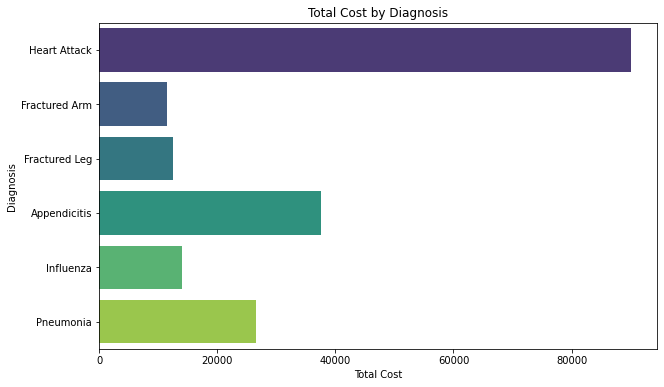

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Aggregating total cost by diagnosis
cost_by_diagnosis = patient_df.groupBy("diagnosis").agg(F.sum("total_cost").alias("total_cost"))

# Converting PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = cost_by_diagnosis.toPandas()

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="total_cost", y="diagnosis", data=pandas_df, palette="viridis")
plt.title("Total Cost by Diagnosis")
plt.xlabel("Total Cost")
plt.ylabel("Diagnosis")
plt.show()


10. Distribution of Diagnosis Pie Chart

Business Case: Gain insights into the prevalence of various diagnoses, facilitating resource planning, and focusing healthcare efforts on prevalent medical conditions for improved patient care and operational efficiency.

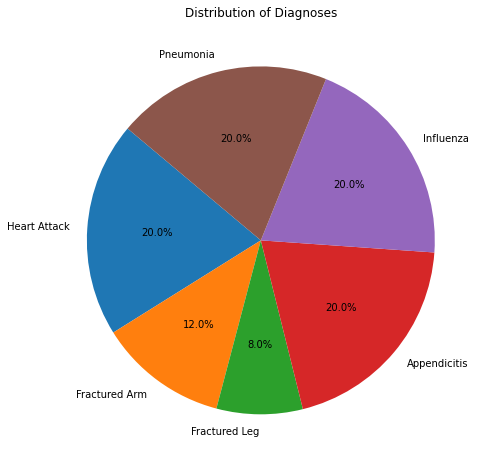

In [10]:
# Counting occurrences of each diagnosis
diagnosis_counts = patient_df.groupBy("diagnosis").count()

# Converting PySpark DataFrame to Pandas DataFrame for visualization
pandas_counts = diagnosis_counts.toPandas()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(pandas_counts["count"], labels=pandas_counts["diagnosis"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Diagnoses")
plt.show()
